In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import kagglehub

path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
DATASET_DIR = os.path.join(path, 'Aerial_Landscapes')
GRID_SIZE = (4, 4)
LBP_P = 24
LBP_R = 3

## Extracting LBP Features using Basic and Spatial Methods

In [2]:
def extract_basic_lbp_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    lbp = local_binary_pattern(gray, P=LBP_P, R=LBP_R, method='uniform')
    
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, LBP_P + 3),
                           range=(0, LBP_P + 2))
    
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

def extract_spatial_lbp_features(image, grid_size=(4, 4)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    grid_h, grid_w = h // grid_size[0], w // grid_size[1]
    features = []

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            block = gray[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            lbp = local_binary_pattern(block, P=LBP_P, R=LBP_R, method='uniform')
            hist, _ = np.histogram(lbp.ravel(),
                                   bins=np.arange(0, LBP_P + 3),
                                   range=(0, LBP_P + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)
            features.extend(hist)
    return features

## Data Analysis

In [3]:
def load_data(dataset_path):
    X_basic, X_spatial, y = [], [], []
    classes = sorted(os.listdir(dataset_path))
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        img_files = os.listdir(class_path)
        for idx, img_name in enumerate(tqdm(img_files, desc=f"Loading {class_name}")):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))
            basic_features = extract_basic_lbp_features(img)
            spatial_features = extract_spatial_lbp_features(img, grid_size=GRID_SIZE)
            X_basic.append(basic_features)
            X_spatial.append(spatial_features)
            y.append(class_name)
    
    return np.array(X_basic), np.array(X_spatial), np.array(y)

X_basic, X_spatial, y = load_data(DATASET_DIR)

Loading River: 100%|██████████| 800/800 [00:21<00:00, 36.84it/s]


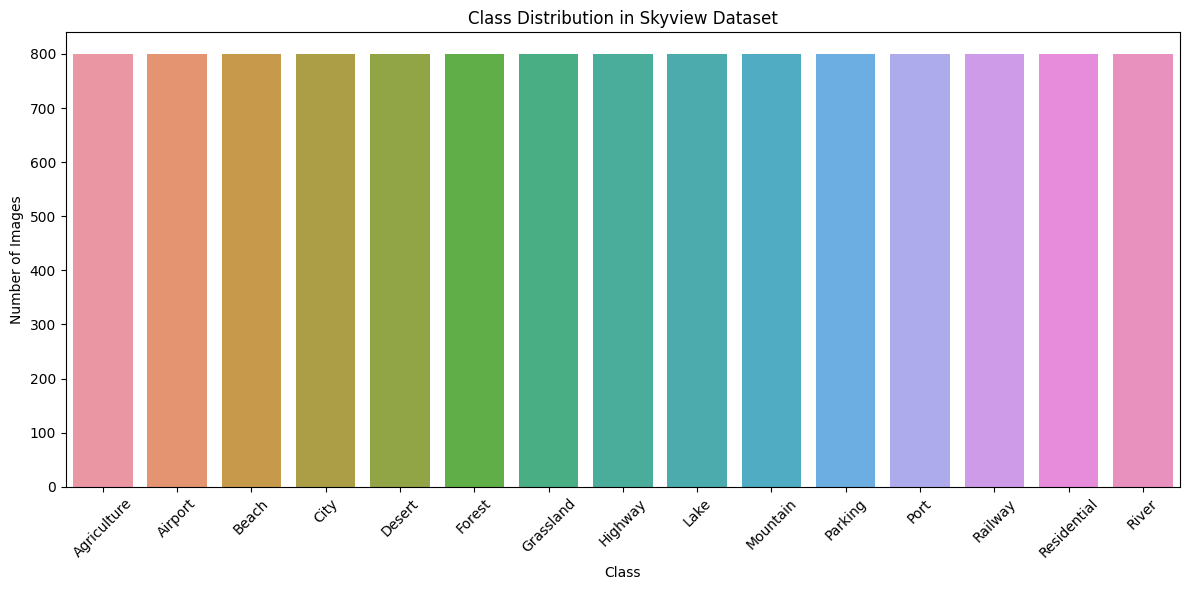

In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(x=y, order=sorted(np.unique(y)))
plt.title("Class Distribution in Skyview Dataset")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

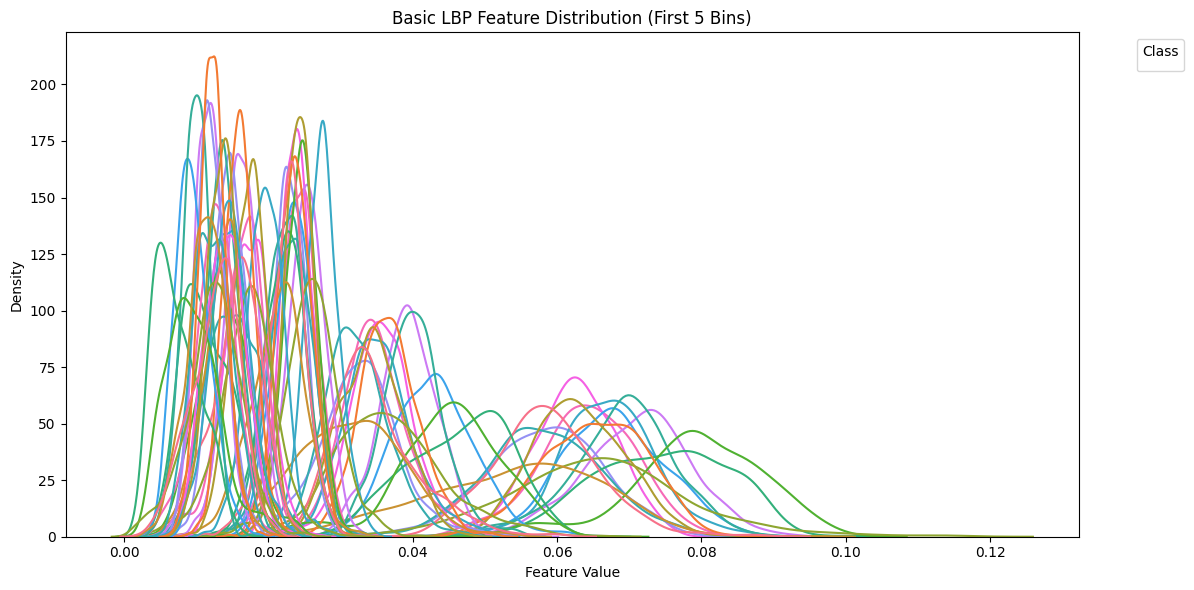

In [5]:
basic_df = pd.DataFrame(X_basic, columns=[f"Bin_{i}" for i in range(X_basic.shape[1])])
basic_df['Class'] = y
plt.figure(figsize=(12, 6))
for i in range(5):  # Plot first 5 bins for clarity
    sns.kdeplot(data=basic_df, x=f"Bin_{i}", hue='Class', common_norm=False)
plt.title("Basic LBP Feature Distribution (First 5 Bins)")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

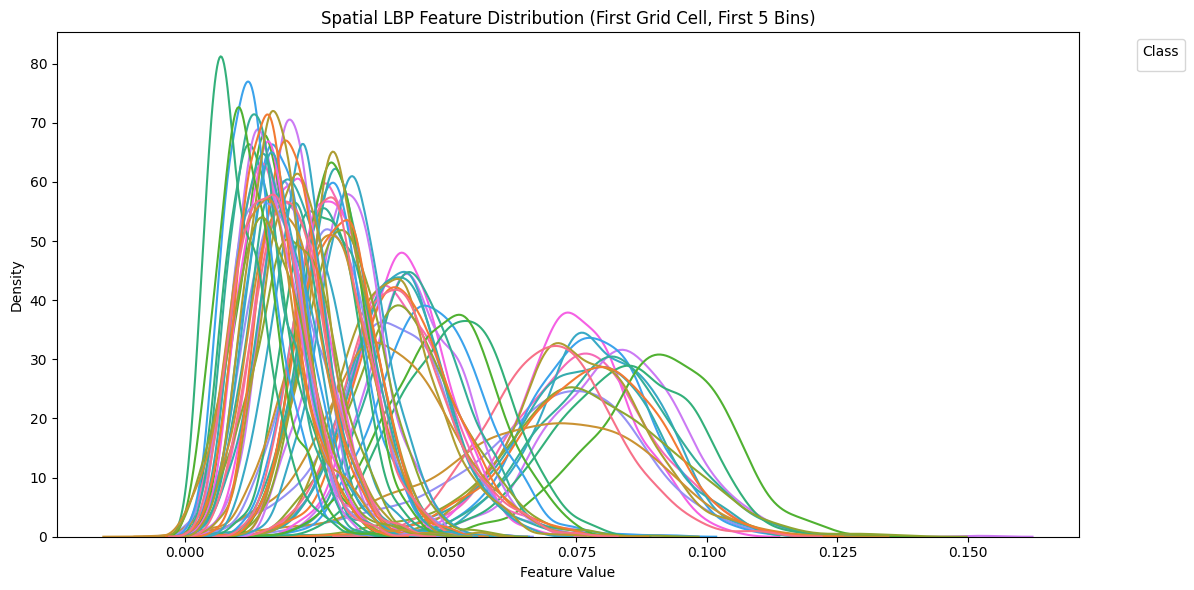

In [6]:
spatial_df = pd.DataFrame(X_spatial[:, :26], columns=[f"Grid_0_0_Bin_{i}" for i in range(26)])
spatial_df['Class'] = y
plt.figure(figsize=(12, 6))
for i in range(5):
    sns.kdeplot(data=spatial_df, x=f"Grid_0_0_Bin_{i}", hue='Class', common_norm=False)
plt.title("Spatial LBP Feature Distribution (First Grid Cell, First 5 Bins)")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_spatial, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

## Training

In [17]:
param_grid = {
    'C': [10, 50],
    'gamma': ['scale', 0.01],
    'kernel': ['poly']
}
grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}


Accuracy: 0.6350
Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.49      0.61      0.54       160
     Airport       0.45      0.46      0.45       160
       Beach       0.72      0.64      0.68       160
        City       0.64      0.60      0.62       160
      Desert       0.72      0.68      0.70       160
      Forest       0.74      0.80      0.77       160
   Grassland       0.71      0.78      0.74       160
     Highway       0.58      0.49      0.53       160
        Lake       0.78      0.65      0.71       160
    Mountain       0.59      0.70      0.64       160
     Parking       0.80      0.74      0.77       160
        Port       0.76      0.65      0.70       160
     Railway       0.68      0.65      0.66       160
 Residential       0.62      0.71      0.66       160
       River       0.37      0.37      0.37       160

    accuracy                           0.64      2400
   macro avg       0.64      0.64      0

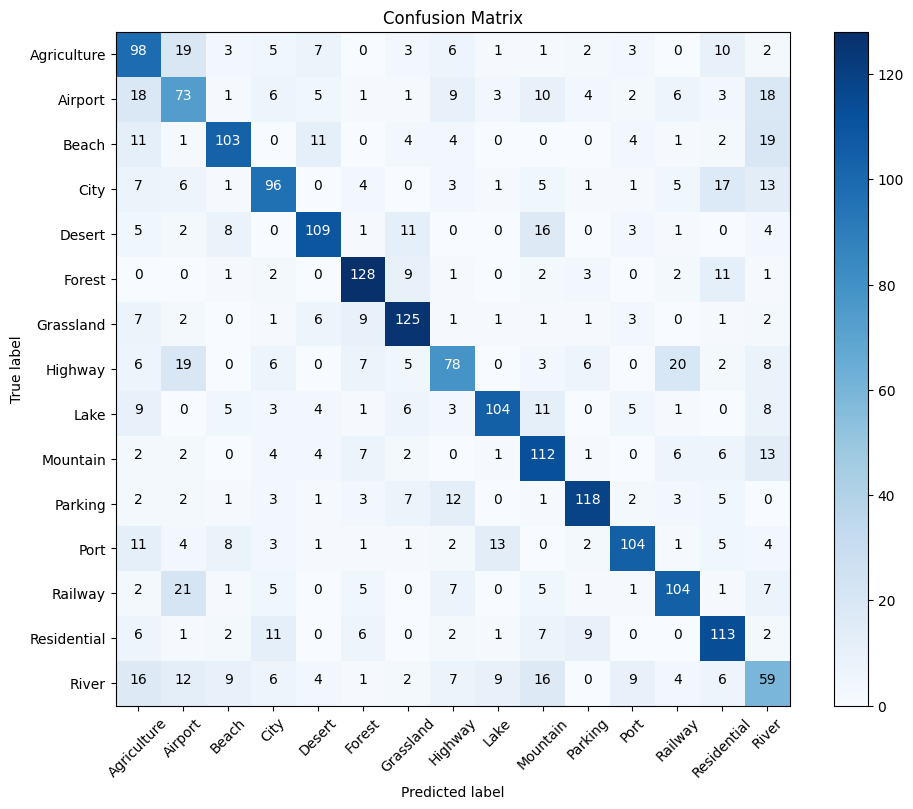

In [11]:
y_pred = best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:")

cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')
plt.show()

In [12]:
y_pred_train_svm = best_model.predict(X_train)
train_accuracy_svm = accuracy_score(y_train, y_pred_train_svm)
test_accuracy_svm = accuracy_score(y_test, y_pred)
print(f"SVM - Training accuracy: {train_accuracy_svm:.4f}, Test accuracy: {test_accuracy_svm:.4f}")
print(f"Difference: {train_accuracy_svm - test_accuracy_svm:.4f}")

SVM - Training accuracy: 0.7596, Test accuracy: 0.6350
Difference: 0.1246


## Loading data with imbalance

In [14]:
def load_data_imbalance(dataset_path, class_counts=None):
    X_basic, X_spatial, y = [], [], []
    classes = sorted(os.listdir(dataset_path))
    
    if class_counts is None:
        class_counts = {cls: 800 for cls in classes}  # Default: 800 images per class
    else:
        class_counts = {cls: count for cls, count in zip(classes, class_counts)}
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        img_files = os.listdir(class_path)
        sampled_files = np.random.choice(img_files, size=min(class_counts[class_name], len(img_files)), replace=False)
        for img_name in tqdm(sampled_files, desc=f"Loading {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))
            basic_features = extract_basic_lbp_features(img)
            spatial_features = extract_spatial_lbp_features(img, grid_size=GRID_SIZE)
            X_basic.append(basic_features)
            X_spatial.append(spatial_features)
            y.append(class_name)
    
    return np.array(X_basic), np.array(X_spatial), np.array(y)

class_counts = [800, 700, 600, 500, 400, 350, 300, 250, 200, 150, 100, 80, 70, 60, 50]
X_basic_im, X_spatial_im, y_im = load_data_imbalance(DATASET_DIR, class_counts=class_counts)

Loading River: 100%|██████████| 50/50 [00:01<00:00, 47.38it/s]


## Training on imbalanced data using the same model but tweaked parameters

In [15]:
y_encoded_im = le.fit_transform(y_im)
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X_spatial_im, y_encoded_im, test_size=0.2, random_state=42, stratify=y_encoded_im)

param_grid_im = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}
svm_im = SVC(class_weight='balanced')
grid_search_im = GridSearchCV(svm_im, param_grid_im, cv=5, n_jobs=-1, verbose=2)
grid_search_im.fit(X_train_im, y_train_im)
best_model_im = grid_search_im.best_estimator_

y_pred_im = best_model_im.predict(X_test_im)
print(f"Accuracy: {accuracy_score(y_test_im, y_pred_im):.4f}")
print("Classification Report:")
print(classification_report(y_test_im, y_pred_im, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test_im, y_pred_im))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Accuracy: 0.6193
Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.64      0.57      0.61       160
     Airport       0.63      0.59      0.61       140
       Beach       0.83      0.72      0.77       120
        City       0.51      0.55      0.53       100
      Desert       0.76      0.76      0.76        80
      Forest       0.68      0.71      0.70        70
   Grassland       0.67      0.75      0.71        60
     Highway       0.45      0.48      0.47        50
        Lake       0.83      0.75      0.79        40
    Mountain       0.33      0.60      0.43        30
     Parking       0.55      0.55      0.55        20
        Port       0.57      0.50      0.53        16
     Railway       0.33      0.36      0.34        14
 Residential       0.21      0.25      0.23        12
       River       0.00      0.00      0.00        10

    accuracy                    

In [18]:
from sklearn.metrics import f1_score, precision_recall_curve, auc

y_pred_im = best_model_im.predict(X_test_im)
print("\nWeighted F1-score:", f1_score(y_test_im, y_pred_im, average='weighted'))
print("\nMacro F1-score:", f1_score(y_test_im, y_pred_im, average='macro'))


Weighted F1-score: 0.6243304323828419

Macro F1-score: 0.5355978330107158
